# Blue Bikes Data Visualization and Feature Analysis

This notebook explores the processed Blue Bikes dataset through visualizations and statistical analysis to understand which factors influence trip demand.

## Contents:
1. **Overall Trip Patterns** - Temporal trends across all stations
2. **Feature Correlation Analysis** - Which features correlate most with trip demand
3. **Case Study: Individual Station Analysis** - Deep dive into one high-volume station
4. **Feature Relationships** - How weather, day of week, and seasonality affect ridership
5. **Key Findings** - Summary of insights for modeling

---

**Data:** Processed dataset from `data/processed/merged_data.csv`

**Date Range:** 2022-01-01 to 2025-09-30

**Stations:** 611 unique stations across Greater Boston (note that only 573 are still active in 2025)

In [1]:
# 03_visualizations.ipynb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load processed data
df = pd.read_csv('../data/processed/merged_data.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Loaded {len(df)} rows")
df.head()

Loaded 566622 rows


,station_id,start_station_name,date,trip_count,temp_mean,precipitation,wind_speed,snowfall,is_holiday,day_of_week,is_academic_break,month,year
0,H32007,Broadway and Cabot,2024-04-29,2,15.3,0.0,16.4,0.0,0,0,0,4,2024
1,H32007,Broadway and Cabot,2024-05-02,1,12.7,1.9,23.6,0.0,0,3,0,5,2024
2,H32007,Broadway and Cabot,2024-05-03,1,9.9,0.0,16.1,0.0,0,4,0,5,2024
3,H32007,Broadway and Cabot,2024-05-04,1,8.7,0.0,18.7,0.0,0,5,0,5,2024
4,H32007,Broadway and Cabot,2024-05-05,1,9.9,6.4,16.2,0.0,0,6,0,5,2024


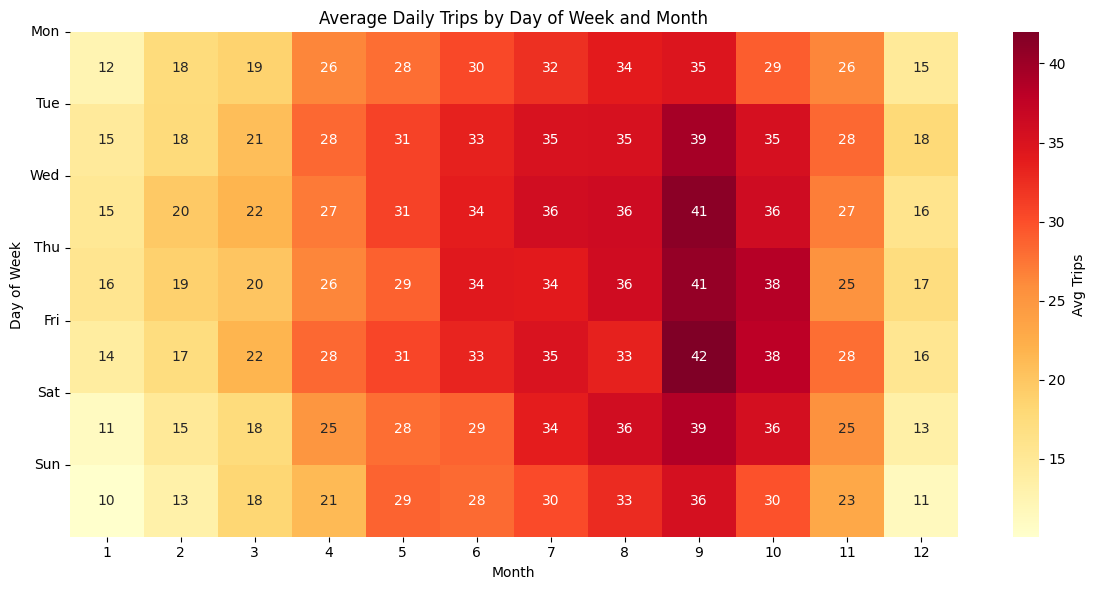

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Aggregate data: average trips per day-of-week and month combination
heatmap_data = df.groupby(['day_of_week', 'month'])['trip_count'].mean().reset_index()

# Pivot for heatmap format
heatmap_pivot = heatmap_data.pivot(index='day_of_week', columns='month', values='trip_count')

# Create heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Avg Trips'})
plt.title('Average Daily Trips by Day of Week and Month')
plt.xlabel('Month')
plt.ylabel('Day of Week')
plt.yticks([0, 1, 2, 3, 4, 5, 6], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.tight_layout()
plt.show()

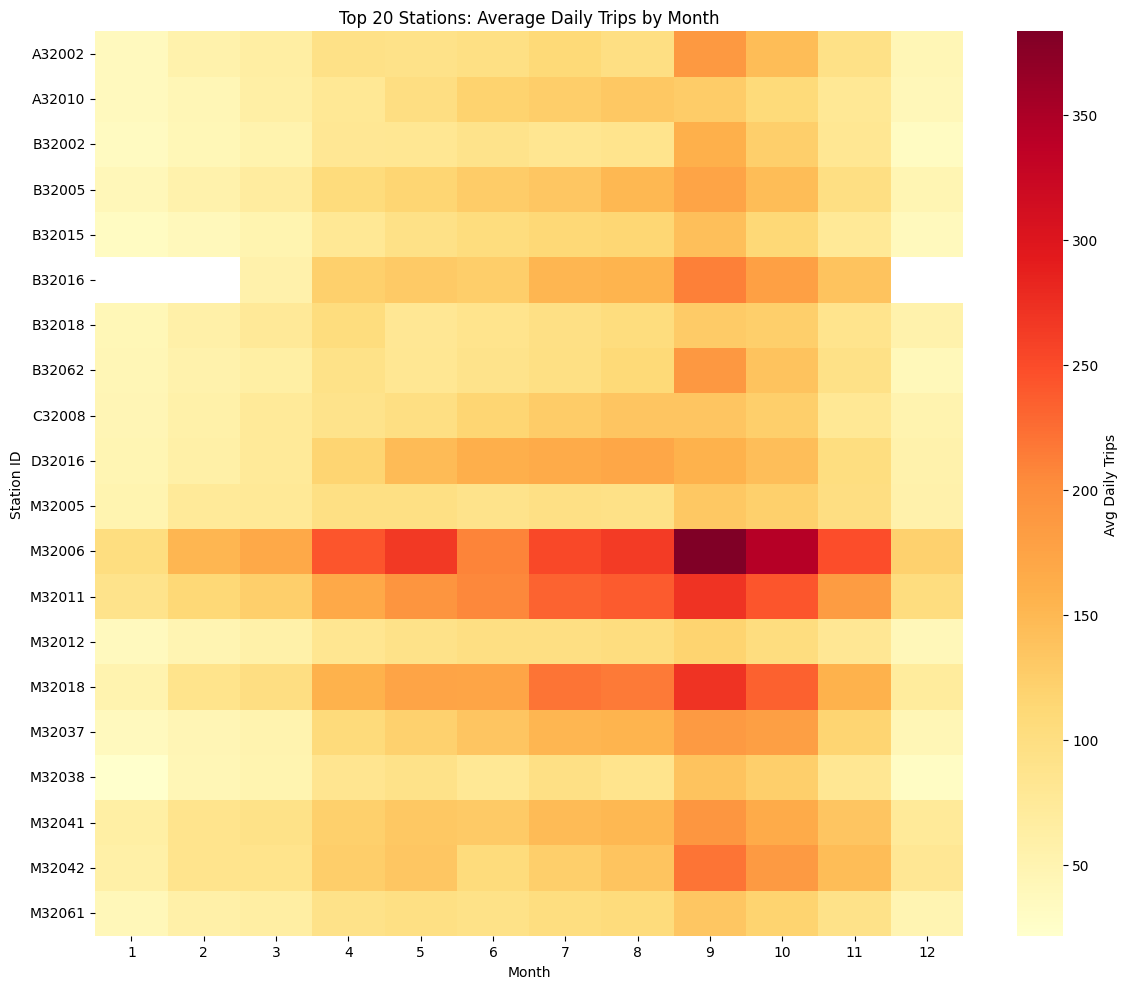

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate average daily trips per station per month
station_month = df.groupby(['station_id', 'month'])['trip_count'].mean().reset_index()
heatmap_data = station_month.pivot(index='station_id', columns='month', values='trip_count')

# Sort stations by total activity (busiest at top)
station_totals = heatmap_data.sum(axis=1).sort_values(ascending=False)
heatmap_data = heatmap_data.loc[station_totals.index]

# Create heatmap
plt.figure(figsize=(12, 20))
sns.heatmap(heatmap_data, cmap='YlOrRd', cbar_kws={'label': 'Avg Daily Trips'}, 
            xticklabels=True, yticklabels=False)  # Too many stations to label
plt.title('Station Activity Heatmap: Average Daily Trips by Month\n(All 611 Stations, Sorted by Total Activity)')
plt.xlabel('Month')
plt.ylabel('Stations (Busiest to Quietest)')
plt.tight_layout()
plt.savefig('station_activity_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Heatmap shows {len(heatmap_data)} stations across 12 months")